# HW2-1: Convoultional Neural Network : CIFAR-10 (pytorch)
Now, we will implement more complex CNN architecture by using pytorch and run it with GPU.
- Here, we will implement
  1) Convolution neural network with pytorch
  2) Training neural networks with above implementation



In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Intro_dl/HW2_student')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/Intro_dl/HW2_student')

Mounted at /content/drive


In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision.transforms as transforms

import numpy as np
from utils import *
from HW_YourAnswer_cnn import *

## Set Random Seed

In [3]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## Use GPU

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


## Data Preprocessing
### CIFAR-10 dataset
We will use CIFAR-10 dataset
- The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.
- We will use 10000 training images and 1000 test images as we did in HW 2-1.


### Define transformation
To augment the dataset, we will use torchvision.transforms.Compose function.

Various data augmentation techniques (resize, crop, flip, contrast, ...) can be used.

Here, we will use simple data augmentations:



In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


## Define custom dataset and loader

In [6]:

from torch.utils.data import Dataset, DataLoader

class CustomCIFAR10 (Dataset):
    def __init__(self,  mode, transform):
        self.mode = mode
        self.transform = transform

        raw_data= get_CIFAR10_data(subtract_mean=False)
        if self.mode == 'train':
            # (10000, 32, 32, 3), (10000,)
            self.data, self.target = raw_data["X_train"],raw_data["y_train"]
        elif self.mode == 'test':
            # (1000, 32, 32, 3), (1000,)
            self.data, self.target = raw_data["X_test"],raw_data["y_test"]
        else:
            raise NotImplementedError

        assert len(self.data) == len(self.target), "Number of data and target should be same!"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # dtype of image and label is numpy
        image, label = self.data[idx], self.target[idx]
        image = Image.fromarray(image.astype(np.uint8))

        if self.transform is not None:
            image = self.transform(image)

        return image, label

def CIFAR10_dataloader(batch_size, train_transform, test_transform):

        train_dataset = CustomCIFAR10(mode='train', transform=train_transform)
        test_dataset = CustomCIFAR10(mode='test', transform=test_transform)

        train_datalader = DataLoader(train_dataset,
                                     batch_size=batch_size,
                                     shuffle=True)

        test_datalader = DataLoader(test_dataset,
                                     batch_size=1,
                                     shuffle=False)
        classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

        return train_datalader, test_datalader, classes


In [7]:
# data loader
batch_size = 32
trainloader, testloader, classes  = CIFAR10_dataloader(batch_size,transform_train,transform_test)

## Visualize training images

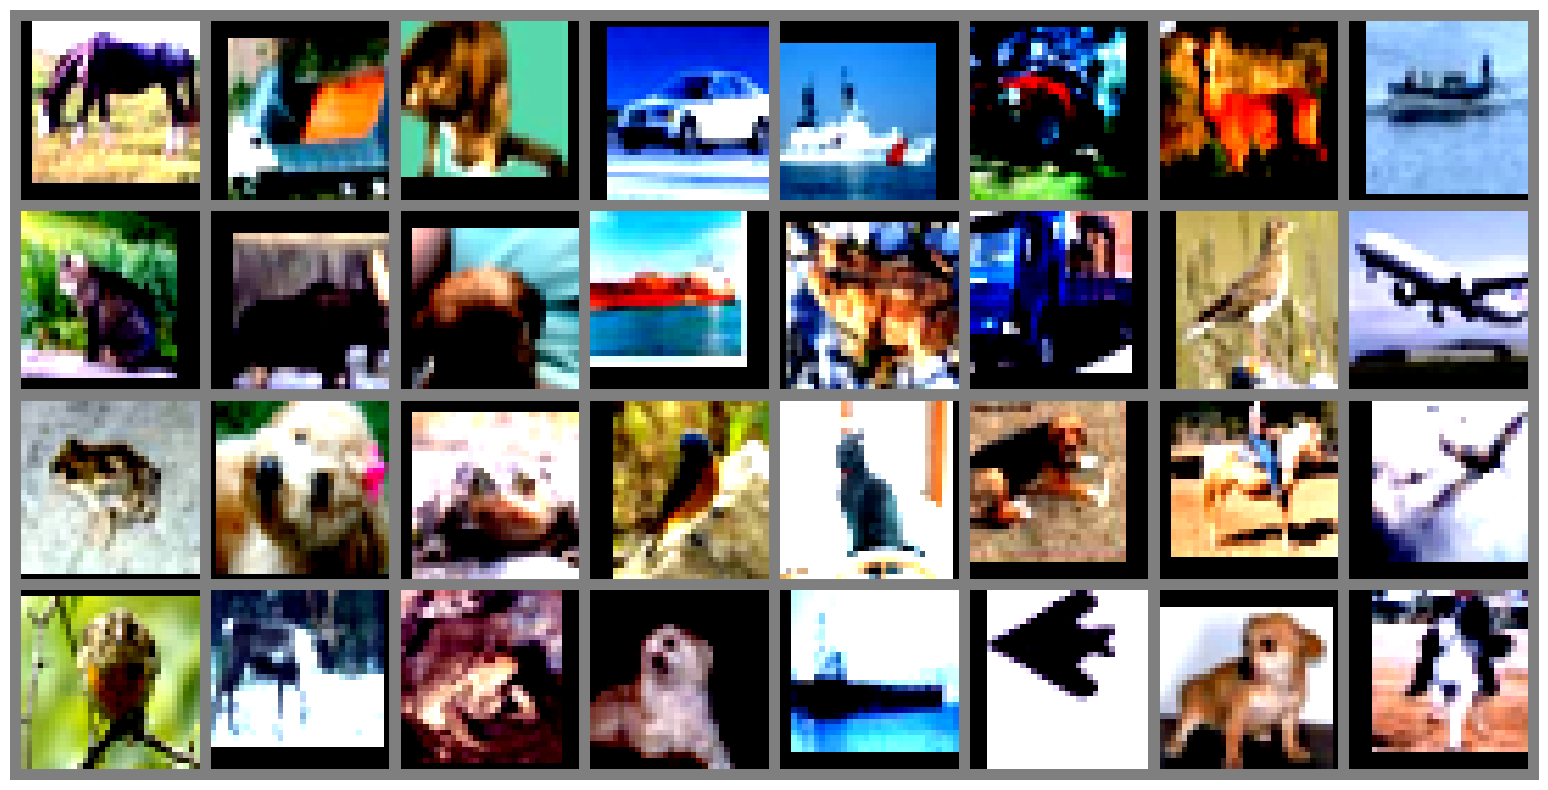

In [8]:
iterator = iter(trainloader)
sample_image, sample_label = next(iterator)

import torchvision
imshow(torchvision.utils.make_grid(sample_image,8))

### To Do: Implement pytorch_CNN
- Implement convolutional neural networks with pytorch (See details in `HW_YourAnswer_cnn.py`) .
    - Feature Extraction Layer Block
      - first layer: Conv, Batchnorm, Relu, Max pool
      - second layer:  Conv, Batchnorm, Relu, Max pool
    - Classification Layer Block
      - first layer: Linear, Relu
      - second layer: Linear, Relu
      - last layer: Linear
- You will implement __init__() and __forward__() function using torch.nn module.


In [9]:
num_classes=len(classes)
net = pytorch_CNN(num_classes)
net.to(device)

pytorch_CNN(
  (conv_layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layer): Sequential(
    (0): Linear(in_features=576, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=4096, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4096, out_features=10, bias=True)
  )
)

## Setting Hyperparameters
Here, we manually set hyperparameters(epochs, lr, ..) that are used for training the model. Hyper-parameters are one of the important factor to train a model up to targeting performance.

In [10]:
epochs = 20
learning_rate=0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

### Let's training and check the results

You will achieve greater than 55% acccuracy on the training set.

In [11]:
import time
start = time.time()
start_epoch = 0


tr_acc = []
tr_loss = []
te_acc = []
te_loss = []

for epoch in range(epochs):
    net.train()
    train_loss = 0
    train_correct = 0
    test_correct = 0

    for batch_idx, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, predicted = outputs.max(1)
        train_correct += predicted.eq(labels).sum().item()

    tr_loss_i = train_loss/len(trainloader)
    tr_acc_i = 100.*train_correct/len(trainloader.dataset)

    # eval
    net.eval()
    test_loss = 0

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(testloader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)

            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_correct += predicted.eq(labels).sum().item()

    te_loss_i = test_loss/len(testloader)
    te_acc_i = 100.*test_correct/len(testloader.dataset)

    print(f'Epoch: {epoch}, Training loss: {tr_loss_i:.3f}, Training acc: {tr_acc_i:.3f},  Test loss: {te_loss_i:.3f}, Test acc : {te_acc_i:.3f}')

    tr_loss.append( tr_loss_i )
    tr_acc.append ( tr_acc_i )
    te_loss.append(te_loss_i )
    te_acc.append(te_acc_i )


#Time Calculation

finish = time.time() - start
temp_log = "Time Elapse: %s" %(format_time(finish))
print(temp_log)

Epoch: 0, Training loss: 1.854, Training acc: 32.160,  Test loss: 1.628, Test acc : 41.000
Epoch: 1, Training loss: 1.631, Training acc: 39.600,  Test loss: 1.456, Test acc : 47.200
Epoch: 2, Training loss: 1.532, Training acc: 44.200,  Test loss: 1.395, Test acc : 48.800
Epoch: 3, Training loss: 1.473, Training acc: 46.010,  Test loss: 1.328, Test acc : 51.800
Epoch: 4, Training loss: 1.410, Training acc: 48.860,  Test loss: 1.315, Test acc : 52.900
Epoch: 5, Training loss: 1.371, Training acc: 49.860,  Test loss: 1.237, Test acc : 54.500
Epoch: 6, Training loss: 1.328, Training acc: 52.360,  Test loss: 1.267, Test acc : 53.800
Epoch: 7, Training loss: 1.290, Training acc: 53.550,  Test loss: 1.228, Test acc : 57.800
Epoch: 8, Training loss: 1.266, Training acc: 53.980,  Test loss: 1.186, Test acc : 58.000
Epoch: 9, Training loss: 1.243, Training acc: 55.280,  Test loss: 1.190, Test acc : 57.700
Epoch: 10, Training loss: 1.215, Training acc: 55.720,  Test loss: 1.178, Test acc : 58.80

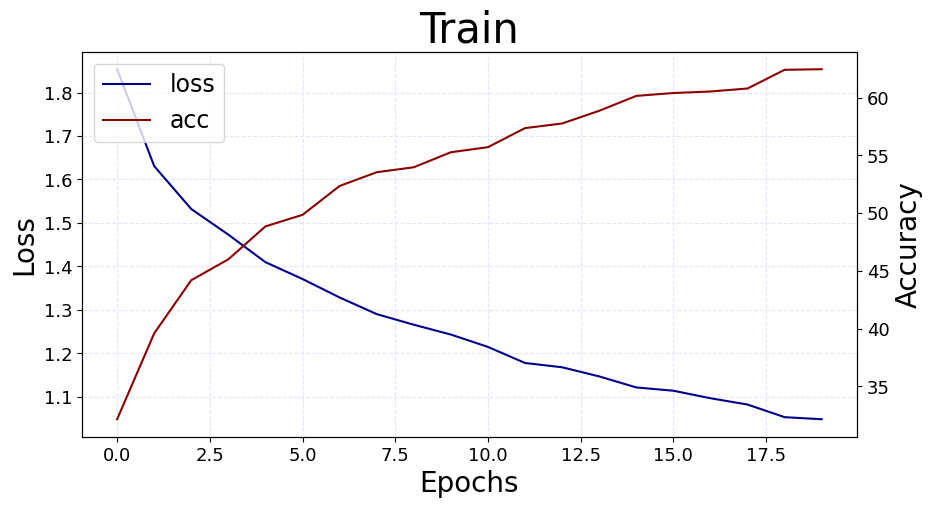

In [12]:
loss_and_acc(tr_acc, tr_loss, 'Train')

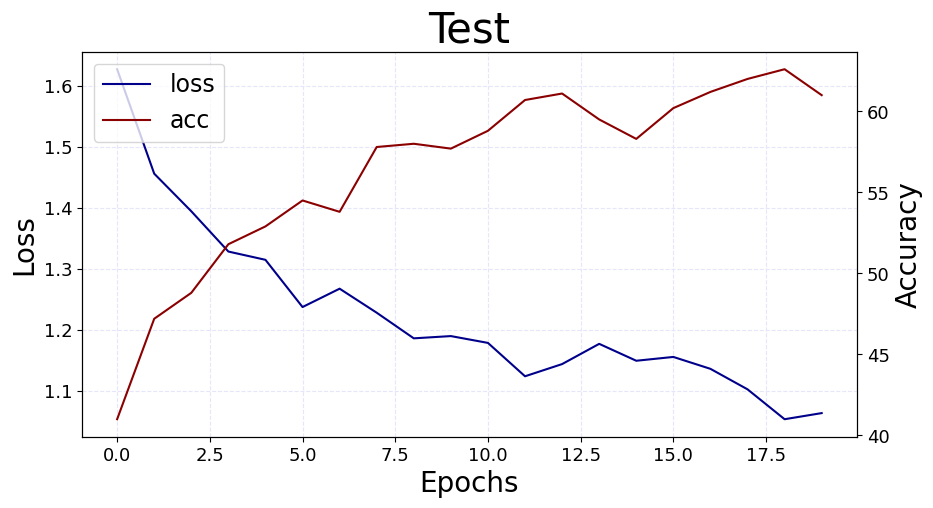

In [13]:
loss_and_acc(te_acc, te_loss, 'Test')

In [14]:
print('The best test accuracy :', np.max(te_acc), 'at epoch', np.argmax(te_acc))

The best test accuracy : 62.6 at epoch 18
